# Generating fake data

This is an idea of generating fake data using model reusability. Instead of broadcasting the data among the nodes and retraining the models, the idea is to broadcast only the model with (max, min and a noisy value). This way, the model can predict some values using a uniform distribution using (max, min and the noise) to create fake data generated by the model.Our hypothesis here is that we can reduce the overhead in communicating the values between nodes where the dataset are huge.

In [10]:
import os
import json
from datetime import datetime
from json import JSONDecodeError
import pandas as pd
import numpy as np

def generate_dataset(home_dir,dataset_name):
    
    """generate_dataset: This function assumes the data is 
    distributed in folders from a parent directory. 
    Each folder contains comma-separated files where each 
    row is defined with a JSON notation.
    Arguments:
        home_dir [string] -- parent directory
        dataset_name [ [string] ] -- Target folder name
    Returns:
        {data_df} -- Pandas dataframe with all the information joined,
                    cleaned and ready to use.
    """
    home_dir = home_dir +"/" + dataset_name
    pi_dirs = os.listdir(home_dir)
    data_list = []
    columns = None
    
    for pi_dir in pi_dirs:
        if 'pi' not in pi_dir:
            continue
        curr_dir = os.path.join(home_dir, pi_dir)
        data_file = os.path.join(curr_dir, os.listdir(curr_dir)[0])
        with open(data_file, 'r') as f:
            line = f.readline().strip().replace("'", '"')
            while line != '':
                try:
                    input_json = json.loads(line)
                    sensor_datetime = datetime.fromtimestamp(input_json['time'])
                    input_json['time'] = sensor_datetime
                    input_json['pi'] = pi_dir
                    data_list.append(list(input_json.values()))
                    if columns is None:
                        columns = list(input_json.keys())
                except JSONDecodeError as je:
                    pass
                line = f.readline().strip().replace("'", '"')
    
    data_df = pd.DataFrame(data_list, columns=columns)
    
    #@TODO: Include an argument to decide the target columns we want in the final dataset.
    del data_df['experiment']
    del data_df['device']
    del data_df['time']
    del data_df['pi']
    data_df = data_df.replace(to_replace=' None', value=np.nan).dropna()
    return data_df

# Keys
Xtrain="xtrain"
Xtest="xtest"
Ytrain="ytrain"
Ytest="ytest"

def split_data(x,y, test_size=0.2):
    dd={}
    from sklearn.model_selection import train_test_split
    dd[Xtrain],dd[Xtest],dd[Ytrain],dd[Ytest]=train_test_split(x,y,test_size=test_size,random_state=42)
    return dd

def train_model(x_train, y_train, x_test, y_test):
    
    # svr is a support vector regression model
    from sklearn.svm import SVR
    svr = SVR(kernel='rbf', C=1, gamma=0.1, epsilon=0.1)
    model = svr.fit(x_train,y_train)
    score = model.score(x_test,y_test)

        
    return model,score

def test_model(model,x_test,y_test):
    
    from sklearn.metrics import mean_squared_error
    from numpy import sqrt
    
    predictions = model.predict(x_test)
    y_predicted = pd.DataFrame(predictions, columns=['predicted'])
    
    mse = mean_squared_error(y_test, y_predicted)
    rmse = sqrt(mse)
    
    return mse,rmse,y_predicted

def plot_model(x_test,y_test,y_predicted,name='', x_name='x',y_name='y'):

    import matplotlib.pyplot as plt
    
    plt.scatter(x_test, y_test, c='tab:green', label='original')
    plt.plot(x_test, y_predicted, c='tab:red', label='predicted')
    
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Support Vector Regression ' +str(name))
    plt.legend()
    plt.show()

# Needed for generating classification, regression and clustering datasets
import sklearn.datasets as dt
from sklearn.cluster import KMeans

def generate_data(dataset,n_clusters,x_name,y_name):
    from pandas import DataFrame
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=n_clusters).fit(dataset)
    centroids = kmeans.cluster_centers_
    
    # We build a dictionary for each cluster with the corresponding dataframe using the position obtained in Kmeans
    # We split the x,y into train and test sets
    
    datasets = {}
    
    samples = {kmeans.cluster_centers_[i, 0]: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

    nodes_index=0
    for k in samples.keys():
        datasets["n"+str(nodes_index)]={}
        d = dataset.iloc[samples[k], :]
        
        X=d.copy().drop(columns=[yvar])
        y=d[yvar].copy()
        
        datasets["n"+str(nodes_index)]["full"] = d
        datasets["n"+str(nodes_index)]["split"] = split_data(X,y,test_size=0.2)
        nodes_index = nodes_index +1
        
    return centroids, datasets, kmeans
    

def plot_nodes(dataset,centroids,x_name,y_name,kmeans):
    import matplotlib.pyplot as plt
    labels = ['n{0}'.format(i) for i in range(len(centroids))]
    plt_data = plt.scatter(dataset[x_name], dataset[y_name], c= kmeans.labels_.astype(float))
    plt.colorbar()
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x')
    plt.title('K-means clustering')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    labels = ['n{0}'.format(i) for i in range(K)]
    for i in range (K):
        xy=(centroids[i, 0],centroids[i, 1])
        plt.annotate(labels[i],xy, horizontalalignment='right', verticalalignment='top',
              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.95', 
                                color='b'))

    plt.show()    

In [11]:
home_dir = '../datasets'
dataset = 'GNFUV-USV-Dataset'

# This variable contains the name of the columns and represents the variables we want to study
xvar='temperature'
yvar='humidity'
target_columns=[xvar,yvar]

# D represents the global dataset (all the points).
D = generate_dataset(home_dir,dataset)

from sklearn.preprocessing import StandardScaler

standaritzation = StandardScaler()
standaritzation.fit(D[target_columns])
scaled=standaritzation.transform(D[target_columns])
D_Scaled = D.copy()
D_Scaled[target_columns] = scaled

K=7
centroids,D_,kmeans = generate_data(D_Scaled,K,xvar,yvar)

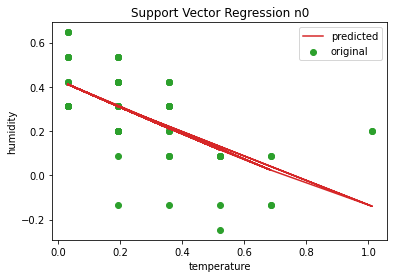

Accuracy of model: n0 === 36.25% (nº of correct predictions)"
Performance of model: n0 === 0.02 (MSE)
How far are the data points from the regression line: n0 === 0.16 (RMSE)


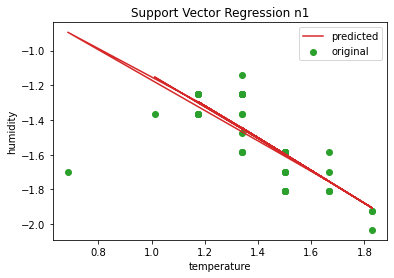

Accuracy of model: n1 === 45.23% (nº of correct predictions)"
Performance of model: n1 === 0.03 (MSE)
How far are the data points from the regression line: n1 === 0.17 (RMSE)


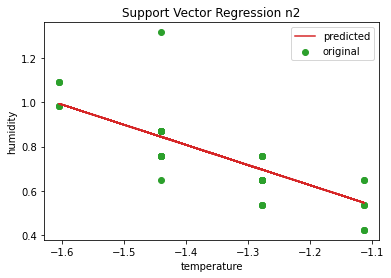

Accuracy of model: n2 === 68.63% (nº of correct predictions)"
Performance of model: n2 === 0.01 (MSE)
How far are the data points from the regression line: n2 === 0.10 (RMSE)


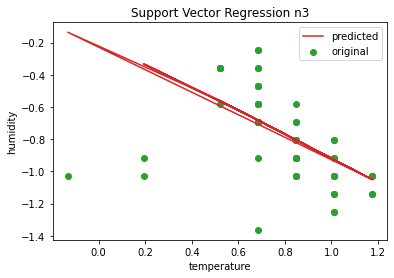

Accuracy of model: n3 === 17.68% (nº of correct predictions)"
Performance of model: n3 === 0.06 (MSE)
How far are the data points from the regression line: n3 === 0.24 (RMSE)


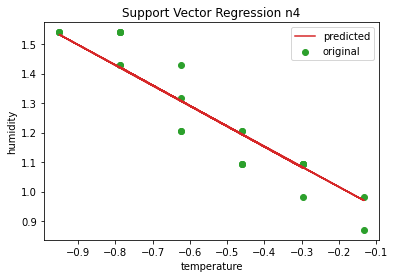

Accuracy of model: n4 === 87.81% (nº of correct predictions)"
Performance of model: n4 === 0.01 (MSE)
How far are the data points from the regression line: n4 === 0.07 (RMSE)


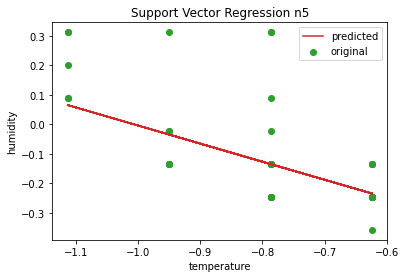

Accuracy of model: n5 === 40.47% (nº of correct predictions)"
Performance of model: n5 === 0.02 (MSE)
How far are the data points from the regression line: n5 === 0.15 (RMSE)


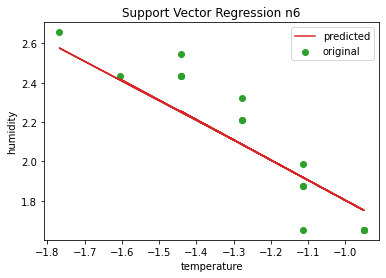

Accuracy of model: n6 === 80.20% (nº of correct predictions)"
Performance of model: n6 === 0.02 (MSE)
How far are the data points from the regression line: n6 === 0.15 (RMSE)


In [13]:
index_model=0
models={}
for k in D_.keys():
    
    # ni is the node i
    ni = "n"+str(index_model)
    
    # di is the dataset corresponding to node i
    di=D_["n"+str(index_model)]["split"]
    
    models[ni]={}
    models[ni]["model"],models[ni]["score"] = train_model(di[Xtrain],di[Ytrain],di[Xtest],di[Ytest])
    models[ni]["mse"],models[ni]["rmse"],models[ni]["prediction"]=test_model(models[ni]["model"],di[Xtest],di[Ytest])
    plot_model(di[Xtest],di[Ytest],models[ni]["prediction"],ni,xvar,yvar)


    print('Accuracy of model: {} === {:.2f}% (nº of correct predictions)"'.format(ni, models[ni]["score"]*100))
    print('Performance of model: {} === {:.2f} (MSE)'.format(ni, models[ni]["mse"]))
    print('How far are the data points from the regression line: {} === {:.2f} (RMSE)'.format(ni, models[ni]["rmse"]))

    index_model = index_model +1

In [53]:
from scipy.stats import sem

# I want to pass model (m1) to node (n0) generate fake data in (n0) and add this data to retrain (m0)
n0 = 'n0'
n1 = 'n1'
# m1 (model for node 1) and m0 (model for node 0)
m1=models[n1]['model']
m0=models[n0]['model']

# d0,d1 represent the datasets from n0,n1 
d0f=D_[n0]['full']
d1f=D_[n1]['full']

d0s=D_[n0]['split']
d1s=D_[n1]['split']


res={}

# Score of m1 using d1 data
res["mse"],res["rmse"],res["prediction"]=test_model(m1,d1s[Xtest],d1s[Ytest])

print("M1 -> mse={0},rmse={1}".format(res["mse"],res["rmse"]))

# Score of m0 using d1 data
res["mse"],res["rmse"],res["prediction"]=test_model(m0,d1s[Xtest],d1s[Ytest])

print("M0 -> mse={0},rmse={1}".format(res["mse"],res["rmse"]))


### Node 1 (n1) needs to transfer to Node 0 (n0) -> (m1,_min,_max,noise) over x_train set [0]
noise = sem(d1f[xvar])
_max = max(d1f[xvar])
_min = min(d1f[xvar])

### Node 0 collects the information (m1,_min,_max,noise) and uses _min and _max to produce f points (fake_x)
f=15
fake_x = np.random.uniform(low=_min, high=_max, size=f)
fake_x = fake_x.reshape(-1, 1)
dfake_x = pd.DataFrame(fake_x,columns=[xvar])


### Node 0 wants to produce the correspondence fake_y -> m1.predict(fake_x)
fake_y = m1.predict(dfake_x)
dfake_y = pd.Series(fake_y)


import copy
d0_fakers = copy.deepcopy(d0s)

xol=d0_fakers[Xtrain].values.tolist()
yol=d0_fakers[Ytrain].values.tolist()


xl = [element for lis in [xol, fake_x] for element in lis]
yl = [element for lis in [yol, fake_y] for element in lis]


dfake_x = pd.DataFrame(xl,columns=[xvar])
dfake_y = pd.Series(yl)

d0_fakers[Xtrain]=dfake_x
d0_fakers[Ytrain]=dfake_y

m0_m1,m0_m1_score= train_model(d0_fakers[Xtrain],d0_fakers[Ytrain],d1s[Xtest],d1s[Ytest])

# Score of m0_m1 using d1 data
res["mse"],res["rmse"],res["prediction"]=test_model(m0_m1,d1s[Xtest],d1s[Ytest])

print("M0M1(fake) -> mse={0},rmse={1}".format(res["mse"],res["rmse"]))

d0_real = copy.deepcopy(d0s)

xol=d0_real[Xtrain].values.tolist()
yol=d0_real[Ytrain].values.tolist()

xrl=[]
yrl=[]
for i in range(f):
    xrl.append(d1s[Xtrain].sample().values)
    yrl.append(d1s[Ytrain].sample().values)
        

xl = [element for lis in [xol, xrl] for element in lis]
yl = [element for lis in [yol, yrl] for element in lis]


dfake_x = pd.DataFrame(xl,columns=[xvar])
dfake_y = pd.Series(yl)

d0_real[Xtrain]=dfake_x
d0_real[Ytrain]=dfake_y

m0_m1,m0_m1_score= train_model(d0_real[Xtrain],d0_real[Ytrain],d1s[Xtest],d1s[Ytest])

# Score of m0_m1 using d1 data
res["mse"],res["rmse"],res["prediction"]=test_model(m0_m1,d1s[Xtest],d1s[Ytest])

print("M0M1(real) -> mse={0},rmse={1}".format(res["mse"],res["rmse"]))







M1 -> mse=0.02873332056717895,rmse=0.16950905747829215
M0 -> mse=1.61041119848357,rmse=1.2690197786021973
M0M1(fake) -> mse=0.17455135163902347,rmse=0.41779343178061507
M0M1(real) -> mse=0.2795747135393792,rmse=0.5287482515709903


In [ ]:
# Fer 30 vegades i mirar quantes vegades i fer la mitjana del mse
# Fer amb tots els models que conté el node